In [1]:
! pip install -U accelerate
! pip install -U transformers
! pip install evaluate
! pip install rouge_score
! pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.9 MB/s eta 0:0

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

checkpoint = "facebook/bart-base"
dataset = load_dataset("cnn_dailymail", "1.0.0")
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
max_text_length = 512

def filter_long_texts(example):
    return len(example["article"].split()) < max_text_length and len(example["highlights"].split()) >= 10 and len(example["highlights"].split()) < 128

filtered_train = dataset["train"].filter(filter_long_texts)
filtered_test = dataset["test"].filter(filter_long_texts)
filtered_val = dataset["validation"].filter(filter_long_texts)

Filter:   0%|          | 0/287113 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11490 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13368 [00:00<?, ? examples/s]

In [6]:
filtered_train, filtered_test, filtered_val

(Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 97720
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 4239
 }),
 Dataset({
     features: ['article', 'highlights', 'id'],
     num_rows: 4995
 }))

In [7]:
filtered_train

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 97720
})

In [8]:
transformed_data = DatasetDict({
    'train': filtered_train,
    'test': filtered_test,
    'validation': filtered_val
})

In [9]:
transformed_data

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 97720
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 4239
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 4995
    })
})

In [10]:
max_input_length = 512
max_target_length = 128
prefix = "summarize: "



def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    labels = tokenizer(text_target=examples["highlights"], max_length= 128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data = transformed_data.map(preprocess_function, batched=True, remove_columns=['article', 'highlights', 'id'])

Map:   0%|          | 0/97720 [00:00<?, ? examples/s]

Map:   0%|          | 0/4239 [00:00<?, ? examples/s]

Map:   0%|          | 0/4995 [00:00<?, ? examples/s]

In [11]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 97720
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4239
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4995
    })
})

In [12]:
train_text_length = [len(text.split()) for text in transformed_data["train"]["article"]]

In [13]:
import pandas as pd
pd.Series(train_text_length).describe()

count    97720.000000
mean       365.355506
std         98.317418
min         18.000000
25%        296.000000
50%        379.000000
75%        447.000000
max        511.000000
dtype: float64

<ipython-input-14-d5fe34979c2a>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


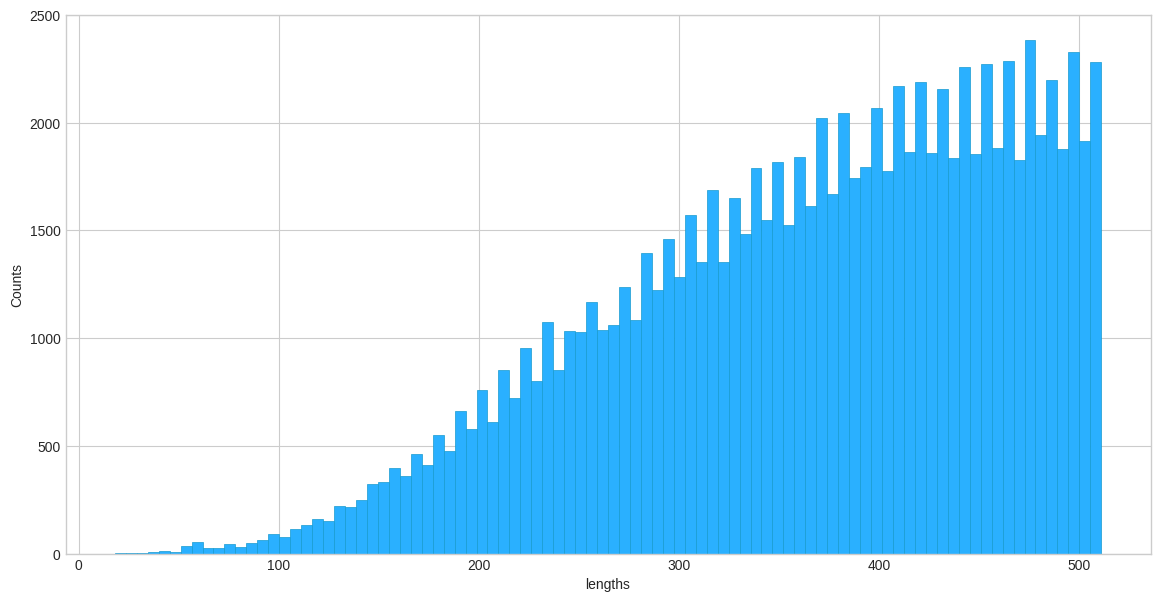

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(train_text_length, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [15]:
test_text_length = [len(text.split()) for text in transformed_data["test"]["article"]]

In [16]:
pd.Series(test_text_length).describe()

count    4239.000000
mean      359.766926
std        96.919258
min        55.000000
25%       289.000000
50%       370.000000
75%       438.500000
max       511.000000
dtype: float64

<ipython-input-17-112a29069cb2>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


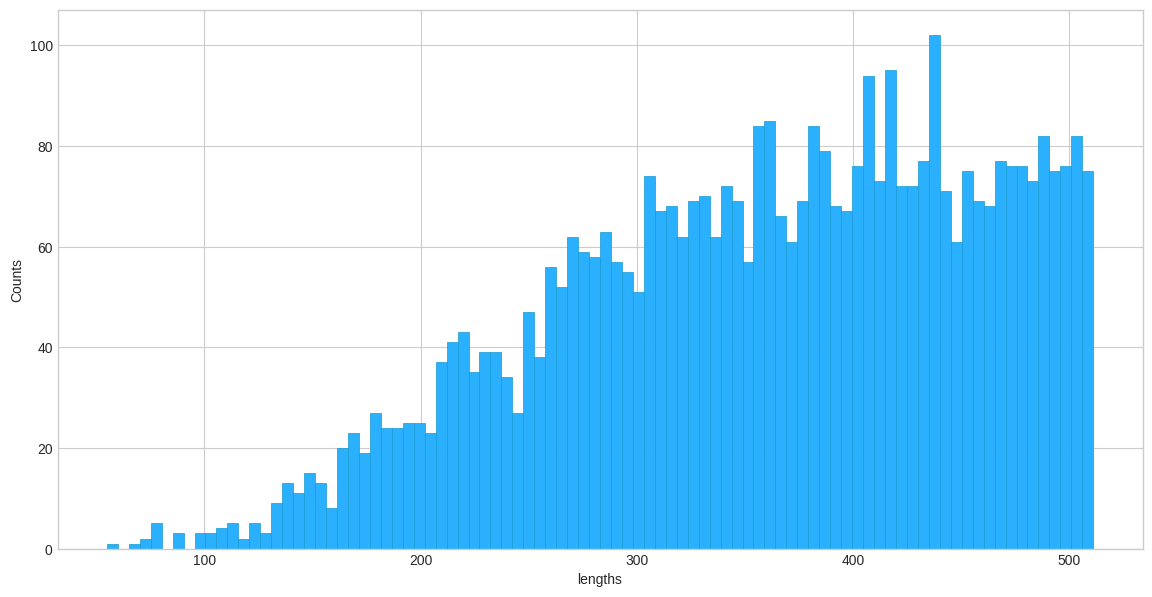

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(test_text_length, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [18]:
val_text_length = [len(l.split()) for l in transformed_data["validation"]["article"]]

In [19]:
pd.Series(val_text_length).describe()

count    4995.000000
mean      357.696697
std        96.493734
min        41.000000
25%       285.000000
50%       368.000000
75%       437.000000
max       511.000000
dtype: float64

<ipython-input-20-1fe88f578e30>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


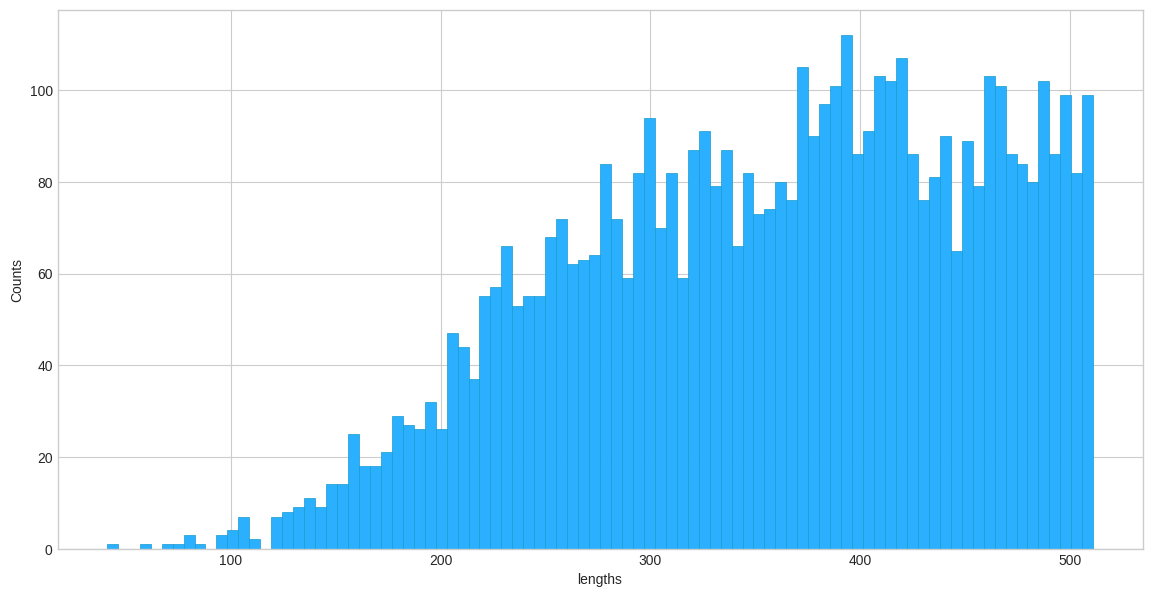

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(val_text_length, bins=90, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [21]:
train_l_length = [len(l.split()) for l in transformed_data["train"]["highlights"]]

In [22]:
pd.Series(train_l_length).describe()

count    97720.000000
mean        44.876555
std         14.782029
min         10.000000
25%         35.000000
50%         43.000000
75%         53.000000
max        127.000000
dtype: float64

<ipython-input-23-b7abe6ba8ea6>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


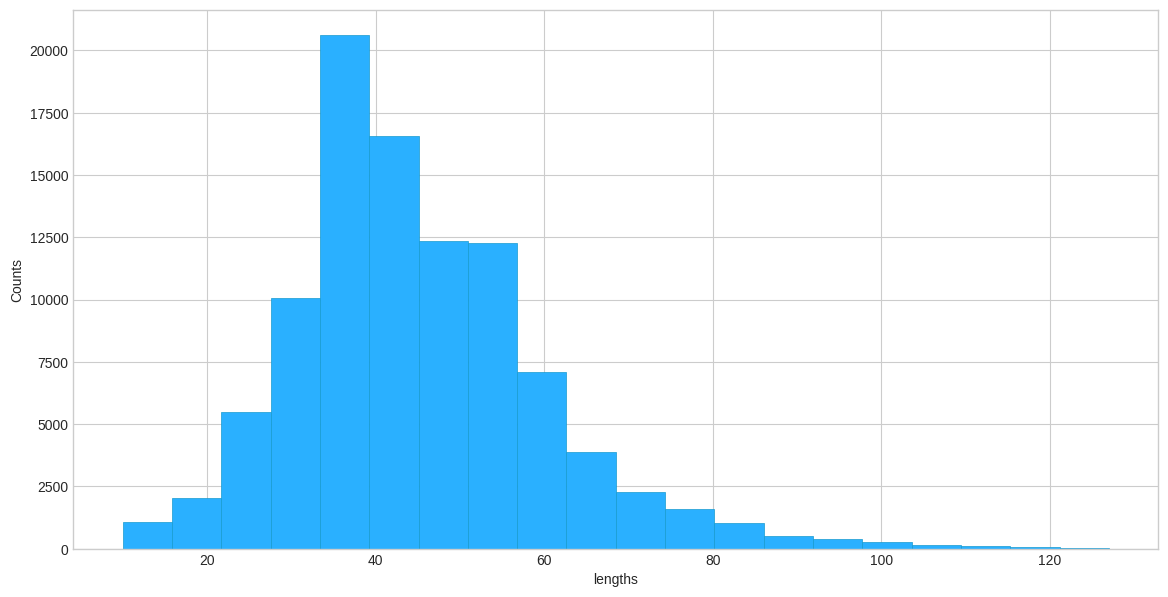

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(train_l_length, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [24]:
test_l_length = [len(l.split()) for l in transformed_data["test"]["highlights"]]

In [25]:
pd.Series(test_l_length).describe()

count    4239.000000
mean       48.705827
std        15.625183
min        13.000000
25%        37.000000
50%        47.000000
75%        57.000000
max       126.000000
dtype: float64

<ipython-input-26-d738664296b7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


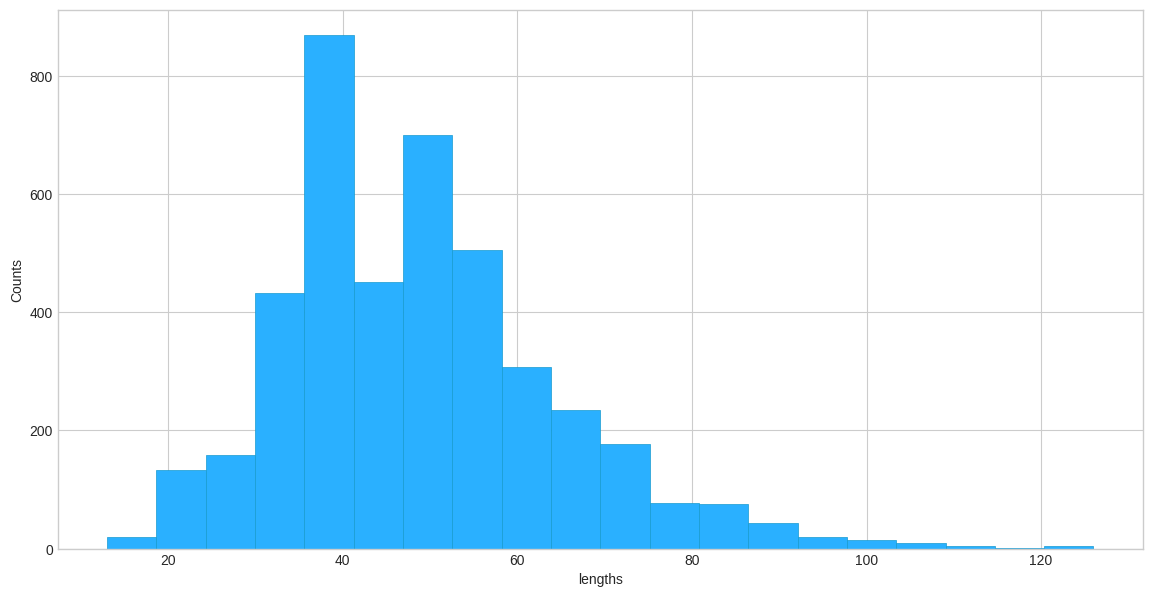

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(test_l_length, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [27]:
val_l_length = [len(l.split()) for l in transformed_data["validation"]["highlights"]]

In [28]:
pd.Series(val_l_length).describe()

count    4995.000000
mean       50.138539
std        16.595352
min        10.000000
25%        38.000000
50%        49.000000
75%        59.000000
max       126.000000
dtype: float64

<ipython-input-29-82691322b288>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


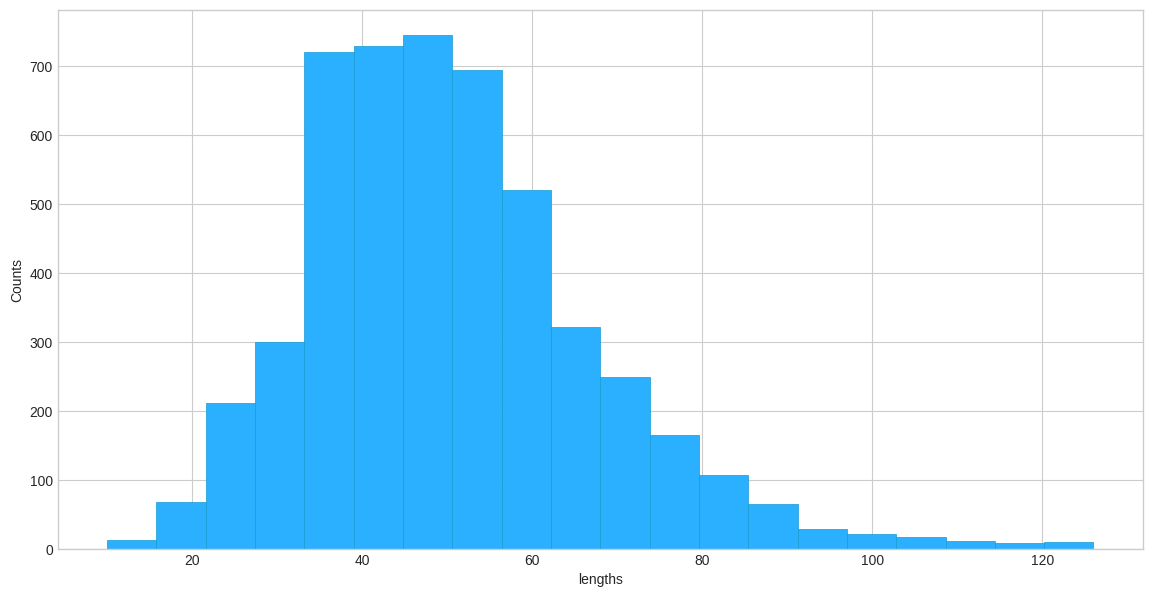

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')

plt.hist(val_l_length, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('lengths')
plt.ylabel('Counts')
plt.show()

In [30]:
from transformers import DataCollatorForSeq2Seq

collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [31]:
import evaluate

rouge = evaluate.load("rouge")

In [32]:
import numpy as np
from bert_score import BERTScorer

bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    P, R, F1 = bert_scorer.score(decoded_preds, decoded_labels)
    bertscore_metrics = {
        'bertscore_precision': P.mean().item(),
        'bertscore_recall': R.mean().item(),
        'bertscore_f1': F1.mean().item()
    }

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result.update(bertscore_metrics)
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [34]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [35]:
output_dir = '/content/drive/MyDrive/checkpoint/'



In [38]:
training_args = Seq2SeqTrainingArguments(
    output_dir= output_dir,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    gradient_accumulation_steps=10,
    save_total_limit= 3,
    num_train_epochs= 3,
    predict_with_generate=True,
    fp16=True,
    report_to="tensorboard",
    push_to_hub=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)



In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
0,1.944700,1.635654,0.272200,0.138800,0.226400,0.226500,0.408600,0.096300,0.247600,20.000000
1,1.788000,1.590951,0.275000,0.142700,0.229400,0.229400,0.415100,0.097800,0.251400,20.000000
2,1.725400,1.583683,0.274100,0.141800,0.228800,0.228900,0.412200,0.096500,0.249300,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


TrainOutput(global_step=1830, training_loss=1.7966246891542863, metrics={'train_runtime': 9245.3315, 'train_samples_per_second': 31.709, 'train_steps_per_second': 0.198, 'total_flos': 8.92603204706304e+16, 'train_loss': 1.7966246891542863, 'epoch': 3.0})

In [55]:
text = """(CNN) -- At least 14 people were killed and 60 others wounded Thursday when a bomb ripped through a crowd waiting to see Algeria's president in Batna, east of the capital of Algiers, the Algerie Presse Service reported.
A wounded person gets first aid shortly after Thursday's attack in Batna, Algeria. The explosion occurred at 5 p.m. about 20 meters (65 feet) from a mosque in Batna, a town about 450 kilometers (280 miles) east of Algiers,
security officials in Batna told the state-run news agency. The bomb went off 15 minutes before the expected arrival of President Abdel-Aziz Bouteflika. It wasn't clear if the bomb was caused by a suicide bomber or if it was
planted, the officials said. Later Thursday, Algeria's Interior Minister Noureddine Yazid Zerhouni said 'a suspect person who was among the crowd attempted to go beyond the security cordon,' but the person escaped 'immediately
after the bomb exploded,' the press service reported. Bouteflika made his visit to Batna as planned, adding a stop at a hospital to visit the wounded before he returned to the capital. There was no immediate claim of
responsibility for the bombing. Algeria faces a continuing Islamic insurgency, according to the CIA. In July, 33 people were killed in apparent suicide bombings in Algiers that were claimed by an al Qaeda-affiliated group.
Bouteflika said terrorist acts have nothing in common with the noble values of Islam, the press service reported. E-mail to a friend . CNN's Mohammed Tawfeeq contributed to this report."""


In [56]:
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained('//content//drive//MyDrive//checkpoint//checkpoint-1500')
model = AutoModelForSeq2SeqLM.from_pretrained('//content//drive//MyDrive//checkpoint//checkpoint-1500')


inputs = tokenizer(text, return_tensors="pt").input_ids
outputs = model.generate(inputs, max_new_tokens=128, do_sample=False)
tokenizer.decode(outputs[0], skip_special_tokens=True)

'NEW: The bomb went off 15 minutes before the expected arrival of President Abdel-Aziz Bouteflika. The explosion occurred at 5 p.m. about 20 meters (65 feet) from a mosque in Batna, a town about 450 kilometers (280 miles) east of Algiers.'